In [1]:
import torch
from torch import nn as nn
from torch import optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision.datasets import MNIST
import torchvision.transforms as transforms
import numpy as np
from matplotlib import pyplot as plt
from scipy import stats

In [2]:
# Trainset
transform = transforms.ToTensor()
all_mnist_train = MNIST('data/', download=True, train=True, transform=transform)
mnist_train = Subset(all_mnist_train, range(10000))

In [3]:
# Testset
all_mnist_test = MNIST('data/', download=True, train=False, transform=transform)
mnist_test = Subset(all_mnist_test, range(6000))
mnist_test

In [4]:
# dataloader
num_workers = 0
batch_size = 128

mnist_trainset = DataLoader(mnist_train, batch_size=batch_size, num_workers=num_workers)
mnist_testset = DataLoader(mnist_test, batch_size=batch_size, num_workers=num_workers)
mnist_trainset

In [5]:
images, labels = next(iter(mnist_trainset))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

In [6]:
def plot_images(images, labels=labels, col=2):
    num_images = len(images)
    
    row = int(np.ceil(num_images/col))
    col = col
    fig, axes = plt.subplots(row, col)
    
    for i in range(row):
        for j in range(col):
            if i*col+j < num_images:
                axes[i, j].imshow(np.squeeze(images[i*col+j]), cmap='gray')
                if len(labels):
                    axes[i, j].set_title(f'{labels[i*col+j].item()}')

    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
    plt.show()

In [8]:
class SDAE(nn.Module):
    def __init__(self, input_size, latent_dim, hidden_layers=[512, 128, 32]):
        super().__init__()
        self.encoder = self.encoder_net(input_size, latent_dim, hidden_layers)
        self.decoder = self.decoder_net(input_size, latent_dim, hidden_layers)
        
    def encoder_net(self, X_size, latent_dim, hidden_layers):
        encoder = nn.Sequential()
        if hidden_layers:
            for i in range(len(hidden_layers)):
                if i == 0:
                    encoder.append(nn.Linear(X_size, hidden_layers[i]))
                    encoder.append(nn.ReLU())
                    continue
                encoder.append(nn.Linear(hidden_layers[i-1],hidden_layers[i]))
                encoder.append(nn.ReLU())
            encoder.append(nn.Linear(hidden_layers[-1], latent_dim))
            encoder.append(nn.ReLU())
        else:
            encoder.append(nn.Linear(X_size, latent_dim))
            encoder.append(nn.ReLU())
        return encoder

    def decoder_net(self, X_size, latent_dim, hidden_layers):
        hidden_layers.reverse()
        decoder = nn.Sequential()
        if hidden_layers:
            for i in range(len(hidden_layers)):
                if i == 0:
                    decoder.append(nn.Linear(latent_dim, hidden_layers[i]))
                    decoder.append(nn.ReLU())
                    continue
                decoder.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
                decoder.append(nn.ReLU())
            decoder.append(nn.Linear(hidden_layers[-1], X_size))
            decoder.append(nn.Sigmoid())
        else:
            decoder.append(nn.Linear(latent_dim, X_size))
            decoder.append(nn.Sigmoid())
        return decoder


    def forward(self, X):
        return self.decoder(self.encoder(X))

    def gaussian_noise(self, X, p=0.2):
        return (X + torch.normal(0, p, X.shape)).clip(0, 1)

    def masking_noise(self, X, p=0.7):
        a = p * torch.ones(X.shape)
        return X * torch.bernoulli(a)

    def poisson_noise(self, X, gain=5):
        a = gain * torch.ones(X.shape)
        p = torch.poisson(a)
        return p/p.max()

    def fit(self, X, lr=0.1, p=0.2, gain=1, noise='gaussian', optimizer='Adam', loss='BCELoss', epochs=20, batch_size=128, shuffle=True, num_workers=0):
        optimizer = getattr(optim, optimizer)(self.parameters(), lr=lr)
        loss_fn = getattr(nn, loss)()
        
        mnist_trainset = DataLoader(X, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
        for epoch in range(1, epochs+1):
            train_loss = 0.0
            batch_num = 0
    
            for data in mnist_trainset:
                images, _ = data
                if noise == 'gaussian':
                    noised_images = self.gaussian_noise(images, p=p)
                elif noise == 'masking':
                    noised_images = self.masking_noise(images, p=p)
                elif noise == 'poisson':
                    noised_images = self.poisson_noise(images, gain=gain)
    
                optimizer.zero_grad()
                noised_images = noised_images.view(images.size(0), -1)
                y_hat = self.forward(noised_images)
                loss = loss_fn(y_hat, images.view(images.size(0), -1))
                loss.backward()
                optimizer.step()
    
                print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {loss.item()*noised_images.size(0):.6f}', end='\r')
                train_loss += loss.item()*noised_images.size(0)
                batch_num += noised_images.size(0)
    
            train_loss = train_loss / len(mnist_trainset)
            print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {train_loss:.6f}')

    def predict_encoder(self, X, batch_size=128):
        result = torch.tensor([])
    
        mnist_testset = DataLoader(X, batch_size=batch_size, num_workers=0)
    
        for i, data in enumerate(mnist_testset):
            images, _ = data
            images = images.view(images.size(0), -1)
            result = torch.concat([result, self.encoder(images)], axis=0)           
        return result

    def predict_decoder(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        return self.decoder(X)

    def predict(self, X, batch_size=128):
        result = torch.tensor([])
    
        mnist_testset = DataLoader(X, batch_size=batch_size, num_workers=0)
    
        for i, data in enumerate(mnist_testset):
            try:
                images, _ = data
            except:
                images = data
            images = images.view(images.size(0), -1)
            result = torch.concat([result, self.forward(images)], axis=0)
        return result

In [9]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0)

In [51]:
dae = SDAE(28*28, 64, hidden_layers=[])
dae

SDAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=64, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=784, bias=True)
    (1): Sigmoid()
  )
)

In [52]:
dae.apply(init_weights)
dae.fit(mnist_train, epochs=20, lr=0.001, p=0.7, noise='masking', batch_size=20, optimizer='Adam', loss='MSELoss')

Epoch: 1 [10000/10000], Loss: 1.087049
Epoch: 2 [10000/10000], Loss: 0.571334
Epoch: 3 [10000/10000], Loss: 0.442234
Epoch: 4 [10000/10000], Loss: 0.371658
Epoch: 5 [10000/10000], Loss: 0.328462
Epoch: 6 [10000/10000], Loss: 0.303312
Epoch: 7 [10000/10000], Loss: 0.288840
Epoch: 8 [10000/10000], Loss: 0.277200
Epoch: 9 [10000/10000], Loss: 0.269540
Epoch: 10 [10000/10000], Loss: 0.265546
Epoch: 11 [10000/10000], Loss: 0.260247
Epoch: 12 [10000/10000], Loss: 0.258324
Epoch: 13 [10000/10000], Loss: 0.254579
Epoch: 14 [10000/10000], Loss: 0.253302
Epoch: 15 [10000/10000], Loss: 0.251257
Epoch: 16 [10000/10000], Loss: 0.249128
Epoch: 17 [10000/10000], Loss: 0.247853
Epoch: 18 [10000/10000], Loss: 0.247107
Epoch: 19 [10000/10000], Loss: 0.246099
Epoch: 20 [10000/10000], Loss: 0.245206


In [39]:
def plot_generated_images(images, labels=None, model=dae, noise='masking', p=0.7, gain=1):
    row = len(images)
    col = 3
    fig, axes = plt.subplots(row, col)
    if noise == 'masking':
        noisy_images = model.masking_noise(images, p=p)
    elif noise == 'gaussian':
        noisy_images = model.gaussian_noise(images, p=p)
    else:
        noisy_images = model.poisson_noise(images, gain=gain)

    generated_images = model.predict(noisy_images).detach().numpy().reshape(-1, 28,28)
    
    for i in range(row):
        for j in range(col):
            if j == 0:
                axes[i, j].imshow(np.squeeze(generated_images[i]), cmap='gray')
                if len(labels):
                    axes[i, j].set_title(f'Generated: {labels[i].item()}')
                continue
            if j == 1:
                axes[i, j].imshow(np.squeeze(noisy_images[i]), cmap='gray')
                if len(labels):
                    axes[i, j].set_title(f'{noise} noise: {labels[i].item()}')
                continue
            axes[i, j].imshow(np.squeeze(images[i]), cmap='gray')
            if len(labels):
                axes[i, j].set_title(f'Original: {labels[i].item()}')

    plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=1.5, wspace=0.4)
    plt.show()

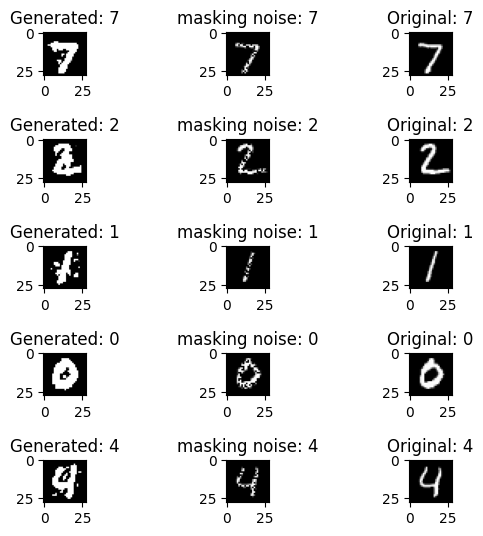

In [40]:
num = 5
plot_generated_images(all_mnist_test.data[mnist_test.indices][:num],labels=all_mnist_test.targets[mnist_test.indices][:num], model=dae, noise='masking', p=0.7)

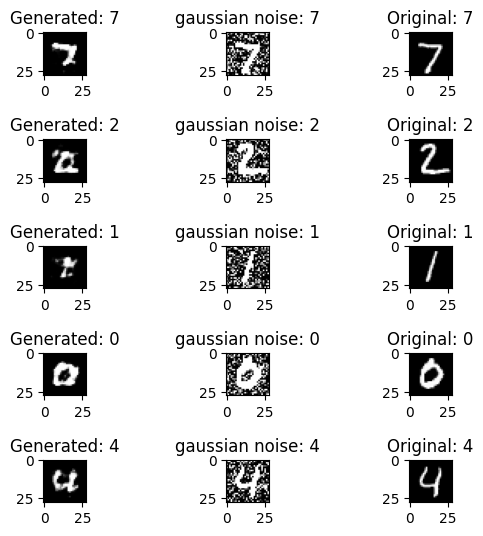

In [41]:
num = 5
plot_generated_images(all_mnist_test.data[mnist_test.indices][:num],labels=all_mnist_test.targets[mnist_test.indices][:num], model=dae, noise='gaussian', p=0.9)

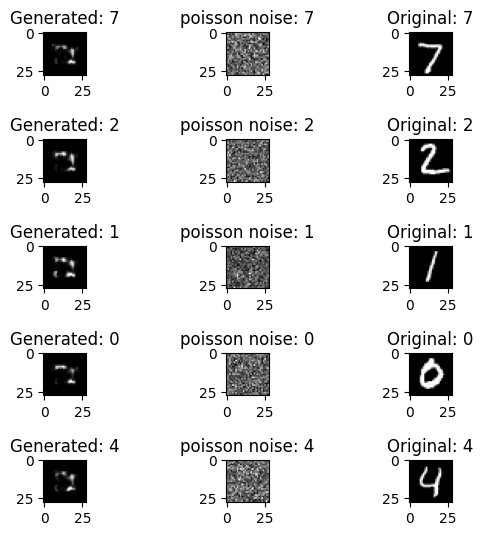

In [42]:
num = 5
plot_generated_images(all_mnist_test.data[mnist_test.indices][:num],labels=all_mnist_test.targets[mnist_test.indices][:num], model=dae, noise='poisson', p=0.7, gain=5)

In [53]:
encoders = dae.predict_encoder(mnist_test, batch_size=256)
encoders.shape

torch.Size([6000, 64])

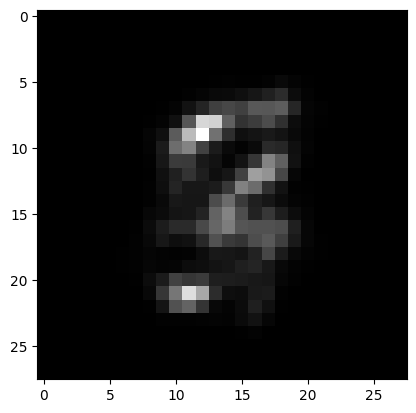

In [54]:
plt.imshow(dae.predict_decoder([np.random.uniform(4, 5) for _ in range(64)]).detach().numpy().reshape(28, 28), cmap='gray')

In [55]:
sdae = SDAE(28*28, 2, hidden_layers=[256, 64, 16])
sdae

SDAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=2, bias=True)
    (7): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=256, bias=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [58]:
sdae.apply(init_weights)
sdae.fit(mnist_train, epochs=20, lr=0.001, p=0.7, gain=5, noise='masking', batch_size=20, optimizer='Adam', loss='BCELoss')

Epoch: 1 [10000/10000], Loss: 5.195235
Epoch: 2 [10000/10000], Loss: 4.388523
Epoch: 3 [10000/10000], Loss: 4.215114
Epoch: 4 [10000/10000], Loss: 4.089797
Epoch: 5 [10000/10000], Loss: 3.999464
Epoch: 6 [10000/10000], Loss: 3.935526
Epoch: 7 [10000/10000], Loss: 3.877988
Epoch: 8 [10000/10000], Loss: 3.845184
Epoch: 9 [10000/10000], Loss: 3.809704
Epoch: 10 [10000/10000], Loss: 3.770706
Epoch: 11 [10000/10000], Loss: 3.744267
Epoch: 12 [10000/10000], Loss: 3.728723
Epoch: 13 [10000/10000], Loss: 3.705820
Epoch: 14 [10000/10000], Loss: 3.689846
Epoch: 15 [10000/10000], Loss: 3.667911
Epoch: 16 [10000/10000], Loss: 3.646574
Epoch: 17 [10000/10000], Loss: 3.639646
Epoch: 18 [10000/10000], Loss: 3.644569
Epoch: 19 [10000/10000], Loss: 3.626387
Epoch: 20 [10000/10000], Loss: 3.602033


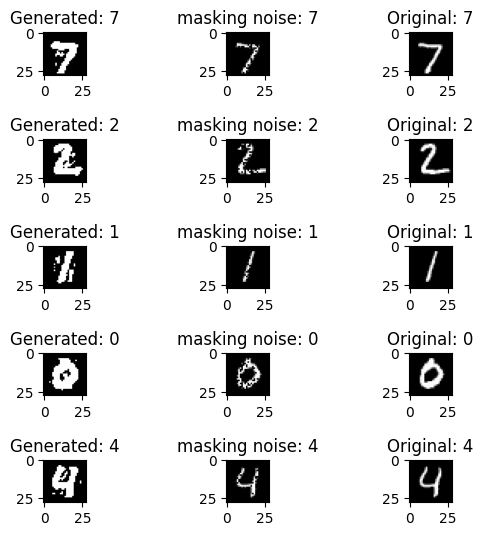

In [62]:
num = 5
plot_generated_images(all_mnist_test.data[mnist_test.indices][:num],labels=all_mnist_test.targets[mnist_test.indices][:num], model=dae, noise='masking', p=0.7, gain=1)

In [66]:
class ConvSDAE(nn.Module):
    def __init__(self, input_size, latent_dim):
        super().__init__()
        self.encoder = self.encoder_net(input_size, latent_dim,)
        self.decoder = self.decoder_net(input_size, latent_dim,)
        
    def encoder_net(self, X_size, latent_dim):
        encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(32, 64, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Conv2d(64, 128, kernel_size=(3,3), padding='same'),
            nn.ReLU(),
            nn.MaxPool2d((2,2), padding = 0),
            nn.Flatten(),
            nn.Linear(1152, latent_dim),
            nn.ReLU(),
        )
        return encoder

    def decoder_net(self, X_size, latent_dim):
        decoder = nn.Sequential(
            nn.Linear(latent_dim, 1152),
            nn.Unflatten(1, (128, 3, 3)),
            nn.ConvTranspose2d(128, 64, kernel_size = (3,3), stride = (2,2), padding = 1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size = (2,2), stride = 3, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size = (2,2), stride = 2, padding=(0,0)),
            nn.Sigmoid()   
        )
        return decoder


    def forward(self, X):
        return self.decoder(self.encoder(X))

    def gaussian_noise(self, X, p=0.2):
        return (X + torch.normal(0, p, X.shape)).clip(0, 1)

    def masking_noise(self, X, p=0.7):
        a = p * torch.ones(X.shape)
        return X * torch.bernoulli(a)

    def poisson_noise(self, X, gain=5):
        a = gain * torch.ones(X.shape)
        p = torch.poisson(a)
        return p/p.max()

    def fit(self, X, lr=0.1, p=0.2, gain=1, noise='gaussian', optimizer='Adam', loss='BCELoss', epochs=20, batch_size=128, shuffle=True, num_workers=0):
        optimizer = getattr(optim, optimizer)(self.parameters(), lr=lr)
        loss_fn = getattr(nn, loss)()
        
        mnist_trainset = DataLoader(X, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
        for epoch in range(1, epochs+1):
            train_loss = 0.0
            batch_num = 0
    
            for data in mnist_trainset:
                images, _ = data
                if noise == 'gaussian':
                    noised_images = self.gaussian_noise(images, p=p)
                elif noise == 'masking':
                    noised_images = self.masking_noise(images, p=p)
                elif noise == 'poisson':
                    noised_images = self.poisson_noise(images, gain=gain)
    
                optimizer.zero_grad()
                noised_images = noised_images.view(-1, 1, 28, 28)
                y_hat = self.forward(noised_images)
                loss = loss_fn(y_hat.view(-1, 1, 28, 28), images)
                loss.backward()
                optimizer.step()
    
                print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {loss.item()*noised_images.size(0):.6f}', end='\r')
                train_loss += loss.item()*noised_images.size(0)
                batch_num += noised_images.size(0)
    
            train_loss = train_loss / len(mnist_trainset)
            print(f'Epoch: {epoch} [{batch_num}/{len(X)}], Loss: {train_loss:.6f}')

    def contrastive_fit(self, X, lr=0.1, p=0.2, gain=1, noise='gaussian', optimizer='Adam', loss='BCELoss', epochs=20, batch_size=128, shuffle=True, num_workers=0):
        optimizer = getattr(optim, optimizer)(self.parameters(), lr=lr)
        loss_fn = getattr(nn, loss)()
        
        mnist_trainset = DataLoader(X, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)
    
        for epoch in range(1, epochs+1):
            train_loss = 0.0
            batch_num = 0
    
            for data in mnist_trainset:
                images, _ = data
                x = torch.tensor([])
                y = torch.tensor([])

                for _ in range(3):
                    x = torch.concat([images, self.gaussian_noise(images, p=p)])
                    y = torch.concat([images, images])
                    x = torch.concat([x, self.masking_noise(images, p=p)])
                    y = torch.concat([images, images])
                    x = torch.concat([x, self.poisson_noise(images, gain=gain)])
                    y = torch.concat([images, images])

                
                # shuffle
                idx = torch.randperm(images.size()[0])
                x = x[idx]
                y = y[idx]

                intermediate_loss = 0.0
                for i in range(3):
                    x_i = x[i*batch_size:i*batch_size+batch_size]
                    y_i = y[i*batch_size:i*batch_size+batch_size]
                    optimizer.zero_grad()
                    y_hat = self.forward(x)
                    loss = loss_fn(y_hat.view(-1, 1, 28, 28), y)
                    loss.backward()
                    optimizer.step()
                    intermediate_loss += loss.item()*x_i.size(0)
                print(f'Epoch: {epoch} [{batch_num}/{len(mnist_trainset)*batch_size}], Loss: {intermediate_loss:.6f}', end='\r')                        
                train_loss += intermediate_loss
                batch_num += x.size(0)
    
            train_loss = train_loss / len(mnist_trainset)
            print(f'Epoch: {epoch} [{batch_num}/{len(mnist_trainset)*batch_size}], Loss: {train_loss:.6f}')

    def predict_encoder(self, X, batch_size=128):
        result = torch.tensor([])
    
        mnist_testset = DataLoader(X, batch_size=batch_size, num_workers=0)
    
        for i, data in enumerate(mnist_testset):
            images, _ = data
            images = images.view(images.size(0), -1)
            result = torch.concat([result, self.encoder(images)], axis=0)           
        return result

    def predict_decoder(self, X):
        X = torch.tensor(X, dtype=torch.float32)
        return self.decoder(X)

    def predict(self, X, batch_size=128):
        result = torch.tensor([])
    
        mnist_testset = DataLoader(X, batch_size=batch_size, num_workers=0)
    
        for i, data in enumerate(mnist_testset):
            try:
                images, _ = data
            except:
                images = data
            images = images.view(images.size(0), -1)
            result = torch.concat([result, self.forward(images)], axis=0)
        return result

In [74]:
csdae = ConvSDAE(28*28, 64)
csdae

ConvSDAE(
  (encoder): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (7): ReLU()
    (8): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
    (9): Flatten(start_dim=1, end_dim=-1)
    (10): Linear(in_features=1152, out_features=64, bias=True)
    (11): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=64, out_features=1152, bias=True)
    (1): Unflatten(dim=1, unflattened_size=(128, 3, 3))
    (2): ConvTranspose2d(128, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
    (4): ConvTranspose2d(64, 32, kernel_size=(

In [75]:
csdae.apply(init_weights)
csdae.fit(mnist_train, epochs=10, lr=0.001, p=0.7, gain=1, noise='poisson', batch_size=20, optimizer='Adam', loss='MSELoss')

Epoch: 1 [10000/10000], Loss: 1.862627
Epoch: 2 [10000/10000], Loss: 1.625914
Epoch: 3 [10000/10000], Loss: 1.625227
Epoch: 4 [10000/10000], Loss: 1.625095
Epoch: 5 [10000/10000], Loss: 1.624934
Epoch: 6 [10000/10000], Loss: 1.624619
Epoch: 7 [10000/10000], Loss: 1.624628
Epoch: 8 [10000/10000], Loss: 1.624458
Epoch: 9 [10000/10000], Loss: 1.624520
Epoch: 10 [10000/10000], Loss: 1.624333


In [72]:
csdae.fit(mnist_train, epochs=10, lr=0.001, p=0.7, gain=1, noise='poisson', batch_size=20, optimizer='Adam', loss='MSELoss')

Epoch: 1 [10000/10000], Loss: 1.624606
Epoch: 2 [10000/10000], Loss: 1.624383
Epoch: 3 [10000/10000], Loss: 1.624300
Epoch: 4 [10000/10000], Loss: 1.624264
Epoch: 5 [10000/10000], Loss: 1.624343
Epoch: 6 [10000/10000], Loss: 1.624318
Epoch: 7 [10000/10000], Loss: 1.624267
Epoch: 8 [10000/10000], Loss: 1.624197
Epoch: 9 [10000/10000], Loss: 1.624307
Epoch: 10 [10000/10000], Loss: 1.624112


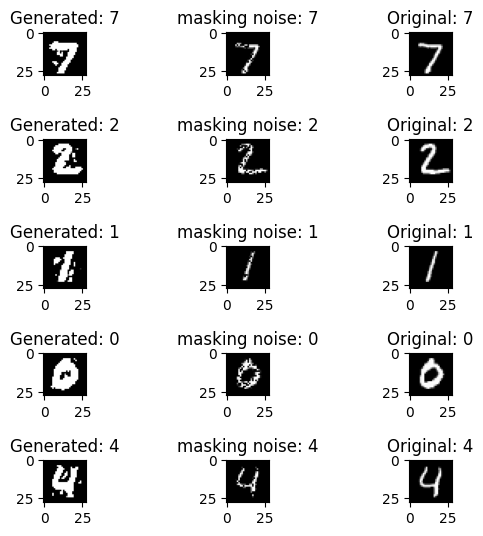

In [78]:
num = 5
plot_generated_images(all_mnist_test.data[mnist_test.indices][:num],labels=all_mnist_test.targets[mnist_test.indices][:num], model=dae, noise='masking', p=0.7, gain=1)